In [219]:
include("../Algebra/Gradients.jl")
include("../Algebra/Hamiltonians.jl")
include("../Algebra/Matrices.jl")
include("../Algebra/Propagators.jl")
include("../Amplitudes/Chebyshev.jl")
include("../Costs/Costs.jl")
include("../Gates/Xgate.jl")
using LinearAlgebra, Optim, Plots
using BenchmarkTools, Distributions, DataFrames, CSV, Measures

In [269]:
ω_c = 5
ω_q = 2
χ = 3e-3
N = 4
amp_c = 1
amp_q = 1

1

In [270]:
I_qubit = Matrix(I,2,2)
I_cavity = Matrix(I,N,N)
#X_gate = kron(x_gate(N, Array[[3,4], [5,6], [7,8]]), I_qubit)
X_gate = kron(x_gate(N, Array[[3,4]]), I_qubit)
#X_gate = kron(x_gate(N, Array[[2,3],[4,5]]), I_qubit)

θ = π/2.5
RZ = kron(Rz(N, Array[[3,4]], θ/2), I_qubit)
RX = kron(Rx(N, Array[[3,4]], θ/4), I_qubit)
Udue = kron(U2(N, Array[[3,4]], [θ/2 θ/3 θ/4] ), I_qubit)
sx = kron(I_cavity, [0 1; 1 0])
sy = kron(I_cavity, [0 -1im; 1im 0])
# generating matrices
a,adag,sp,sm,sz = generate_matrices(N)

ψ_initial = zeros(N)
ψ_initial[1] = 1
ψ_initial = kron(ψ_initial/norm(ψ_initial), [0,1])

ψ_initial_rand = rand(N)
ψ_initial_rand = kron(ψ_initial_rand/norm(ψ_initial_rand), [0,1])
ψ_final_u = Udue * ψ_initial_rand
ψ_final_x = RX * ψ_initial_rand
ψ_final_x_gate = X_gate * ψ_initial_rand
ψ_final_superposition = kron(ones(N)/norm(ones(N)), [0,1])

ψ_final_k = zeros(N)
ψ_final_k[4] = 1
ψ_final_k = kron(ψ_final_k/norm(ψ_final_k), [0,1])

8-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0

In [271]:
H_drift = χ * adag * a * sz / 2

8×8 Matrix{Float64}:
 0.0  0.0  0.0      0.0     0.0     0.0    0.0      0.0
 0.0  0.0  0.0      0.0     0.0     0.0    0.0      0.0
 0.0  0.0  0.0015   0.0     0.0     0.0    0.0      0.0
 0.0  0.0  0.0     -0.0015  0.0     0.0    0.0      0.0
 0.0  0.0  0.0      0.0     0.003   0.0    0.0      0.0
 0.0  0.0  0.0      0.0     0.0    -0.003  0.0      0.0
 0.0  0.0  0.0      0.0     0.0     0.0    0.0045   0.0
 0.0  0.0  0.0      0.0     0.0     0.0    0.0     -0.0045

In [272]:
disp(b) = exp(b * adag - b' * a)
snap(x) = kron(Diagonal(exp.(-1im.*x)),I_qubit)

ECD(β) = exp(β/2 * adag - β'/2 * a) * sp + exp(-β/2 * adag + β'/2 * a) * sm
ROT(ϕ, θ) = exp(-1im * θ / 2 * ( sx * cos(ϕ) + sy * sin(ϕ) )) 

ROT (generic function with 1 method)

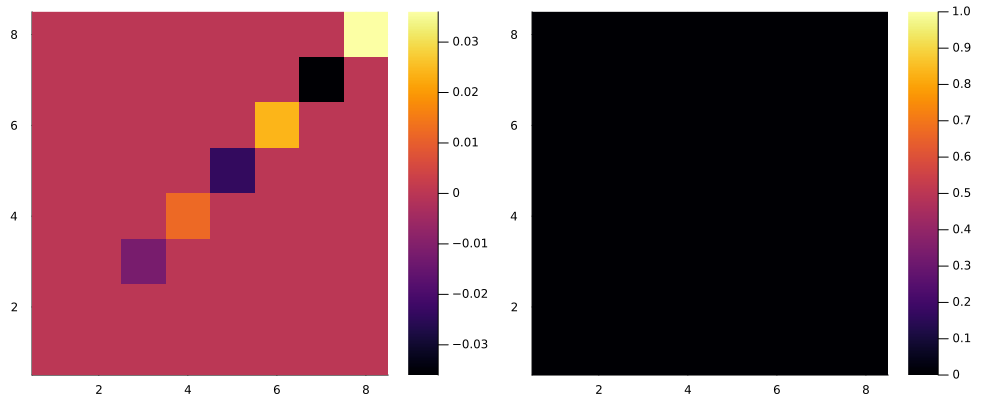

In [273]:
function commutator(A,B)
    return A*B - B*A
end
t1 = 1
t2 = 3

A = cis(H_drift*t1)*sp*cis(-H_drift*t1)
B = cis(H_drift*t2)*sp*cis(-H_drift*t2)
C = cis(H_drift*t1)
heatmap(imag(sp*C*sm + sm*C*sp))
heatmap(imag(commutator(A,B') + commutator(A',B)), layout=2, subplot=1, size = (1000,400))
heatmap!(real(commutator(A,B') + commutator(A',B)), layout=2, subplot=2)

In [274]:
function mygate(H_drift, sp, sm, T, δt, T0, Ω)

    # initialising the propagator
    dim = size(H_drift,1)
    propagator = Matrix{ComplexF64}(I,dim,dim)

    # time ordered product of the single exponential matrices
    # is this true at all? or we need more time steps aniway?
    for l in T0:δt:T
        H = cis(H_drift*l) * ( Ω * sp + Ω' * sm ) * cis(-H_drift*l)
        infinitesimal_propagator  = cis(- H * δt)
        propagator = infinitesimal_propagator * propagator
    end
   
    return propagator
end

function h1(T,H0,sp,δt)
    dim = size(H0,1)
    integral = zeros(dim,dim)
    for l in 0:δt:T
        integral = integral + (δt * cis(H_drift*l)  * sp * cis(-H_drift*l))
    end
    return integral
end

h1 (generic function with 3 methods)

In [284]:
integral_1 = h1(200,H_drift,sp,1e-2)
integral_2 = h1(200,H_drift,sm,1e-2)

8×8 Matrix{ComplexF64}:
    0.0+0.0im  0.0+0.0im      0.0+0.0im      …      0.0+0.0im      0.0+0.0im
 200.01+0.0im  0.0+0.0im      0.0+0.0im             0.0+0.0im      0.0+0.0im
    0.0+0.0im  0.0+0.0im      0.0+0.0im             0.0+0.0im      0.0+0.0im
    0.0+0.0im  0.0+0.0im  188.223-58.2243im         0.0+0.0im      0.0+0.0im
    0.0+0.0im  0.0+0.0im      0.0+0.0im             0.0+0.0im      0.0+0.0im
    0.0+0.0im  0.0+0.0im      0.0+0.0im      …      0.0+0.0im      0.0+0.0im
    0.0+0.0im  0.0+0.0im      0.0+0.0im             0.0+0.0im      0.0+0.0im
    0.0+0.0im  0.0+0.0im      0.0+0.0im         108.209-136.361im  0.0+0.0im

In [285]:
Jik_gate(Ω) = cis(-(Ω*integral_1 + Ω'*integral_2))

function jik_disp_cost_gate(coefficients, unitary, N, disp, Jik_gate)

    L = Int(length(coefficients)/2)
    αs = coefficients[1: L]
    θs = coefficients[L + 1 : end]

    propagator = Matrix{ComplexF64}(I,N,N)

    for i in 1:L
        propagator = propagator * disp(αs[i]) * Jik_gate(θs[i]) * disp(αs[i])'
    end

    return 1 - norm(tr(propagator*unitary) / N)^2
    
end


function jik_disp_prop(coefficients, unitary, N, disp, Jik_gate)

    L = Int(length(coefficients)/2)
    αs = coefficients[1: L]
    θs = coefficients[L + 1 : end]

    propagator = Matrix{ComplexF64}(I,N,N)

    for i in 1:L
        propagator = propagator * disp(αs[i]) * Jik_gate(θs[i]) * disp(αs[i])'
    end

    return propagator
    
end

jik_disp_prop (generic function with 1 method)

In [286]:
f(x) = jik_disp_cost_gate(x, X_gate, N*2, disp, Jik_gate)
prop(x) = jik_disp_prop(x, X_gate, N*2, disp, Jik_gate)

prop (generic function with 1 method)

In [297]:
blocks = 36
coefficients = ((rand(blocks)*2 .-1) +im*(rand(blocks)*2 .-1)) * 1e-3
f(coefficients)

0.752627385030592

In [298]:
res_x = Optim.optimize(f, coefficients , LBFGS(), Optim.Options(show_trace = true, show_every=10))

Iter     Function value   Gradient norm 
     0     7.526274e-01     9.518153e+00
 * time: 0.00016498565673828125


    10     7.499994e-01     7.571544e-02
 * time: 2.02409291267395


    20     7.499978e-01     3.865357e-02
 * time: 3.031688928604126


    30     7.499971e-01     3.645980e-02
 * time: 4.2526350021362305


    40     7.499964e-01     3.672758e-02
 * time: 5.400208950042725


    50     7.499946e-01     7.113538e-02
 * time: 6.5744500160217285


    60     7.499910e-01     7.289663e-02
 * time: 7.742609024047852


    70     7.499885e-01     7.621393e-02
 * time: 8.859534978866577


    80     7.499870e-01     4.175961e-02
 * time: 10.102752923965454


    90     7.499853e-01     9.481757e-02
 * time: 11.19806694984436


   100     7.499760e-01     3.169230e-01
 * time: 12.89360499382019


   110     7.499489e-01     3.398647e-01
 * time: 14.021602869033813


   120     7.498404e-01     5.330103e-01
 * time: 15.271304845809937


   130     7.497739e-01     2.554515e-01
 * time: 16.47638988494873


   140     7.497460e-01     1.910541e-01
 * time: 17.50314998626709


   150     7.496393e-01     9.950926e-01
 * time: 18.71307897567749


   160     7.487498e-01     5.214737e-01
 * time: 19.751783847808838


   170     7.480408e-01     2.079516e+00
 * time: 20.837044954299927


   180     7.472292e-01     1.007731e+00
 * time: 21.88051700592041


   190     7.467197e-01     7.112186e-01
 * time: 23.16237998008728


InterruptException: InterruptException:

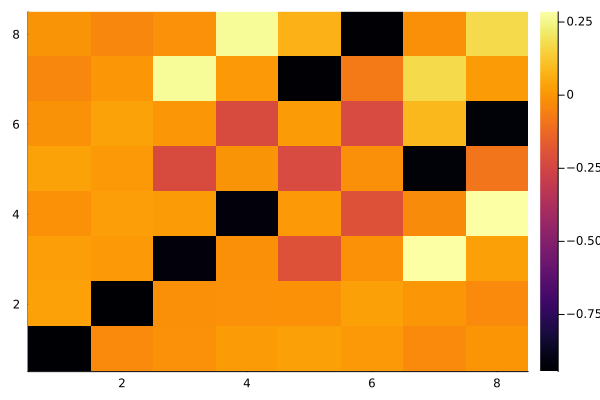

In [299]:
heatmap(real(prop(Optim.minimizer(res_x))))

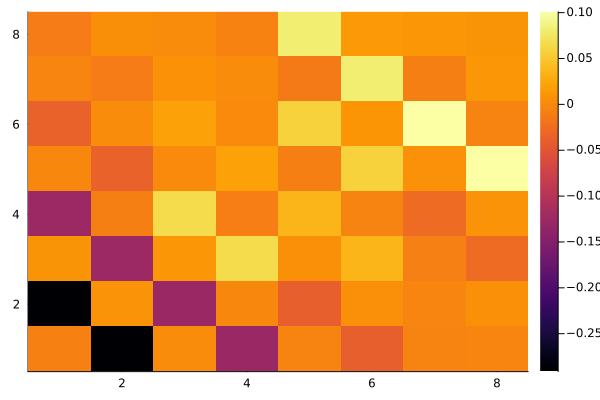

In [300]:
heatmap(imag(prop(Optim.minimizer(res_x))))

In [301]:
Optim.minimizer(res_x)

16-element Vector{ComplexF64}:
  0.3690834319392947 + 3.385387176516347e-5im
  0.4046479775458718 + 5.8050657806487444e-5im
  0.4487410917706109 - 2.4762332244903557e-5im
  0.3483800351807161 - 9.3553561208618e-6im
 0.46247317645198494 + 2.478540762636469e-5im
 0.30114638673430427 + 8.346230767414874e-6im
 0.37557043718897376 + 3.281323633001494e-5im
  0.3063855571149197 - 6.591881473468671e-5im
  -5.760389031416959 + 0.40991231158981867im
  -5.817531037890409 + 0.3568691540278089im
  -5.768806527263764 + 0.3348559084206284im
  -5.955271021651746 + 0.3439111770526289im
  -5.745551581930754 + 0.3144238566828822im
  -5.624893007757477 + 0.3341598589943066im
  -5.878115183793278 + 0.3554730614009961im
  -5.775443441173241 + 0.42895244610356775im